For some reason pystan doesn't work with Python 3 on my Jupyter, so the follow code is ran with Python 2 kernel.

# Call center data set - exponential likelihood with gamma prior. 

Estimate the number of calls per minute for the 11 th hour of the call center data set.

In [1]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
def task1_load_data():
    waiting_times_day = np.loadtxt('call_center.csv')
    current_time = 0
    waiting_times_per_hour = [[] for _ in range(24)]
    for t in waiting_times_day:
        current_hour = int(current_time // 60)
        current_time += t
        waiting_times_per_hour[current_hour].append(t)
    return waiting_times_per_hour[11]
task1_data = task1_load_data()

In [3]:
# Specify Stan model
task1_stan_code = """
data {  
    int<lower=1> nobs;  // number of observations
    real<lower=0> y[nobs];  // observed data
    real<lower=0> alpha;  // fixed hyperparameter
    real<lower=0> beta;   // fixed hyperparameter
}

parameters {
    real<lower=0> lambda;  // parameter of the exponential likelihood
}

model {
    lambda ~ gamma(alpha, beta); // gamma prior over lambda
    y ~ exponential(lambda);  // likelihood function
}

"""

In [4]:
# Compile Stan model
task1_stan_model = pystan.StanModel(model_code=task1_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd05d560989c06212a5ba95e8c34bc0f NOW.


In [5]:
# Gather input data for Stan model
task1_stan_input = {
    'nobs': len(task1_data),
    'y': task1_data,
    'alpha': 1,
    'beta': 0.25
}

In [6]:
# Sample from posterior
task1_stan_output = task1_stan_model.sampling(data=task1_stan_input)

## Posterior 95% confidence interval over $\lambda$

In [7]:
# Get confidence interval from Stan output and print
task1_summary = task1_stan_output.summary(pars=['lambda'], probs=[0.025, 0.975])
print("\t\t".join(task1_summary["summary_colnames"][3:5]))
print("\t".join(task1_summary["summary"][0][3:5].astype(str)))

2.5%		97.5%
13.941762283	15.8279689568


## Histogram of posterior $\lambda$ samples

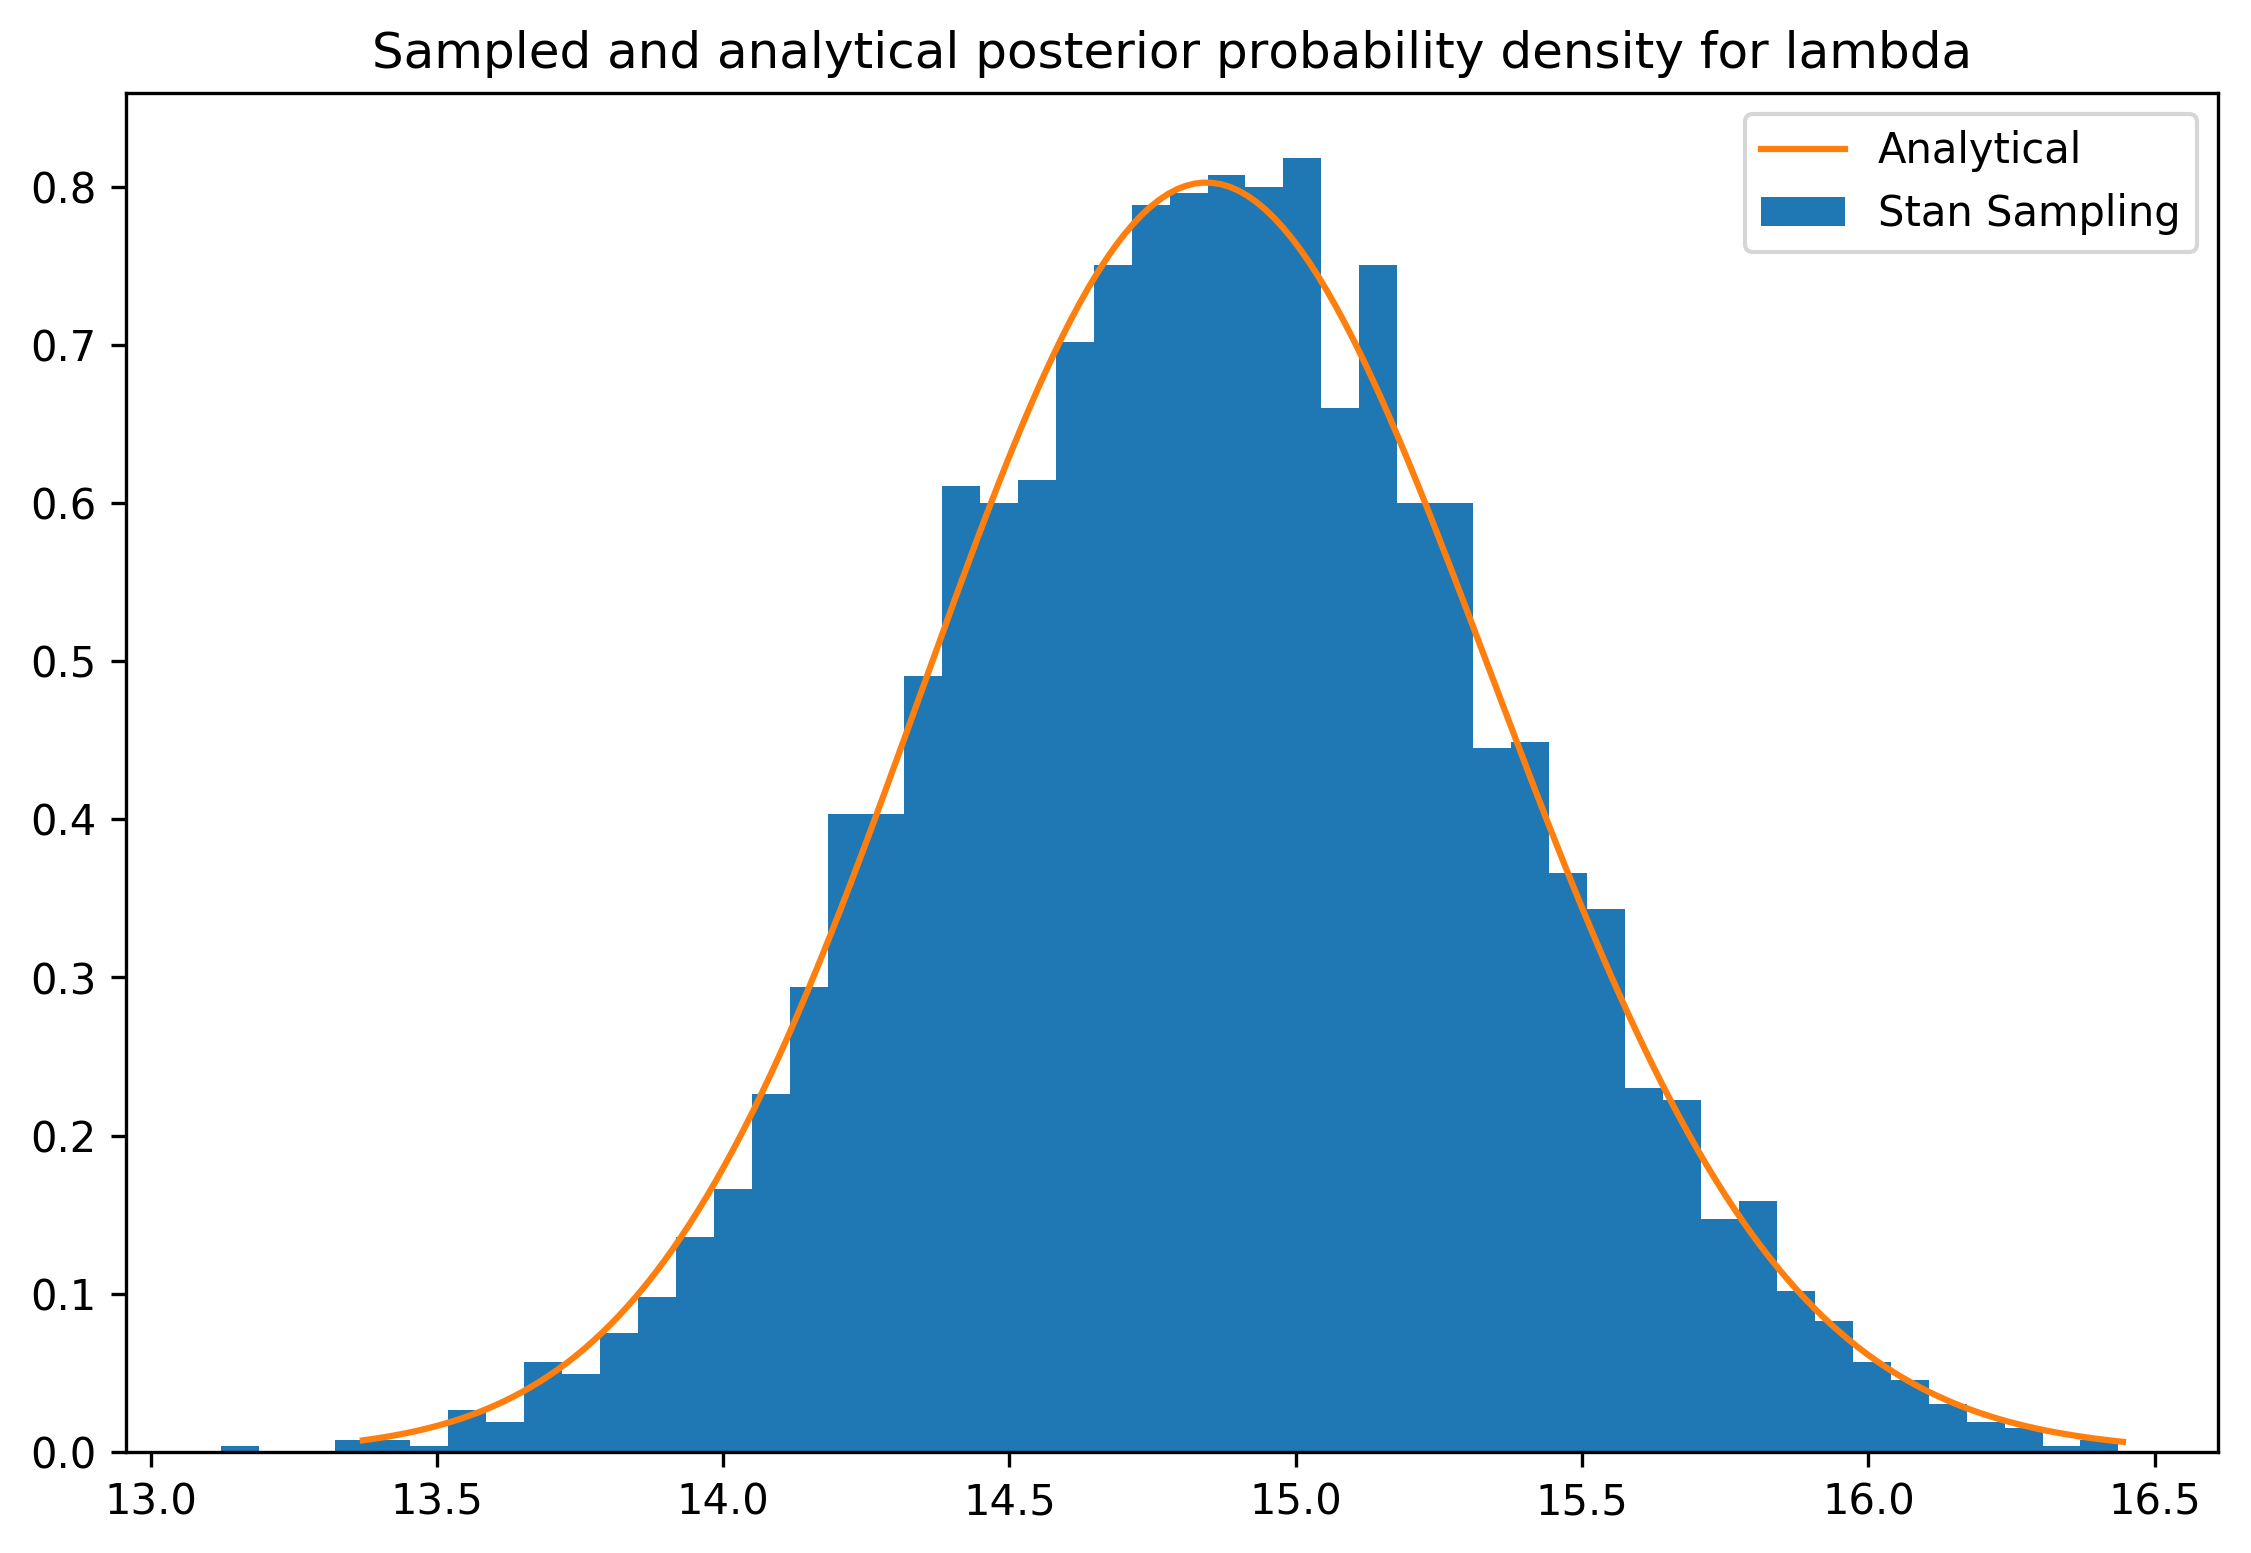

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (9,6)

# Extract samples from Stan and plot histogram
task1_samples = task1_stan_output.extract()
plt.hist(task1_samples['lambda'], bins=50, density=True, label="Stan Sampling")

# Plot analytical curve
def task1_analytical_posterior_curve(data):
    prior_alpha = 1
    prior_beta = 0.25
    # Update posterior using conjugacy
    posterior_alpha = prior_alpha + len(data)
    posterior_beta = prior_beta + sum(data)
    # Construct posterior distribution
    posterior = stats.gamma(a=posterior_alpha, scale=1/posterior_beta)
    interval = (posterior.ppf(0.001), posterior.ppf(0.999))
    # Plot the posterior
    x = np.linspace(interval[0], interval[1], 200)
    y = posterior.pdf(x)
    plt.plot(x, y, label="Analytical")
task1_analytical_posterior_curve(task1_data)

plt.legend()
plt.title('Sampled and analytical posterior probability density for lambda')
plt.show()

# Normal likelihood with normal-inverse-gamma prior.

Justification for Stan code below: Sampling from the normal-inverse-gamma distribution $(\mu, \sigma^2) \sim N\Gamma^{-1}(\mu_0, \lambda, \alpha, \beta)$ can be seen as sampling $\sigma^2$ from the inverse gamma distribution $\Gamma^{-1}(\alpha, \beta)$ and sampling $\mu$ from the normal distribution $N(\mu_0, \sigma^2/\lambda)$.

In [9]:
# Load and preprocess data
def task2_load_data():
    return np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
task2_data = task2_load_data()

In [10]:
# Specify Stan model
task2_stan_code = """
data {  
    int<lower=1> nobs;  // number of observations
    real y[nobs];  // observed data
    real mu_0;  // fixed hyperparameter
    real<lower=0> lambda;  // fixed hyperparameter
    real<lower=0> alpha;  // fixed hyperparameter
    real<lower=0> beta;   // fixed hyperparameter
}

parameters {
    real mu; // mean of the normal likelihood
    real<lower=0> sigma2;  // variance of the normal likelihood
}

model {
    mu ~ normal(mu_0, sqrt(sigma2/lambda)); // normal prior over mu
    sigma2 ~ inv_gamma(alpha, beta); // inverse gamma prior over sigma^2
    y ~ normal(mu, sqrt(sigma2));  // likelihood function
}
"""

In [11]:
# Compile Stan model
task2_stan_model = pystan.StanModel(model_code=task2_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd654d56719ed3c8f494f7efa43d6665 NOW.


In [12]:
# Gather input data for Stan model
task2_stan_input = {
    'nobs': len(task2_data),
    'y': task2_data,
    'mu_0': 0,
    'lambda': 0.054,
    'alpha': 1.12,
    'beta': 0.4
}

In [13]:
# Sample from posterior
task2_stan_output = task2_stan_model.sampling(data=task2_stan_input)

## 95% posterior confidence intervals for the mean $\mu$ and variance $\sigma^2$ of the data.

In [14]:
# Get confidence interval from Stan output and print
task2_mu_summary = task2_stan_output.summary(pars=['mu'], 
                                             probs=[0.025, 0.975])
task2_sigma2_summary = task2_stan_output.summary(pars=['sigma2'], 
                                                 probs=[0.025, 0.975])

print "mu\t\t", "\t\t".join(task2_mu_summary["summary_colnames"][3:5])
print "\t\t","\t".join(task2_mu_summary["summary"][0][3:5].astype(str))
print "\nsigma^2\t\t", "\t\t".join(task2_sigma2_summary["summary_colnames"][3:5])
print "\t\t","\t".join(task2_sigma2_summary["summary"][0][3:5].astype(str))

mu		2.5%		97.5%
		2.80730471582	3.33686261991

sigma^2		2.5%		97.5%
		2.96512814482	4.42103101605


## Take 10 samples from your posterior over $\mu$ and $\sigma^2$ and plot the normal distributions corresponding to them. 

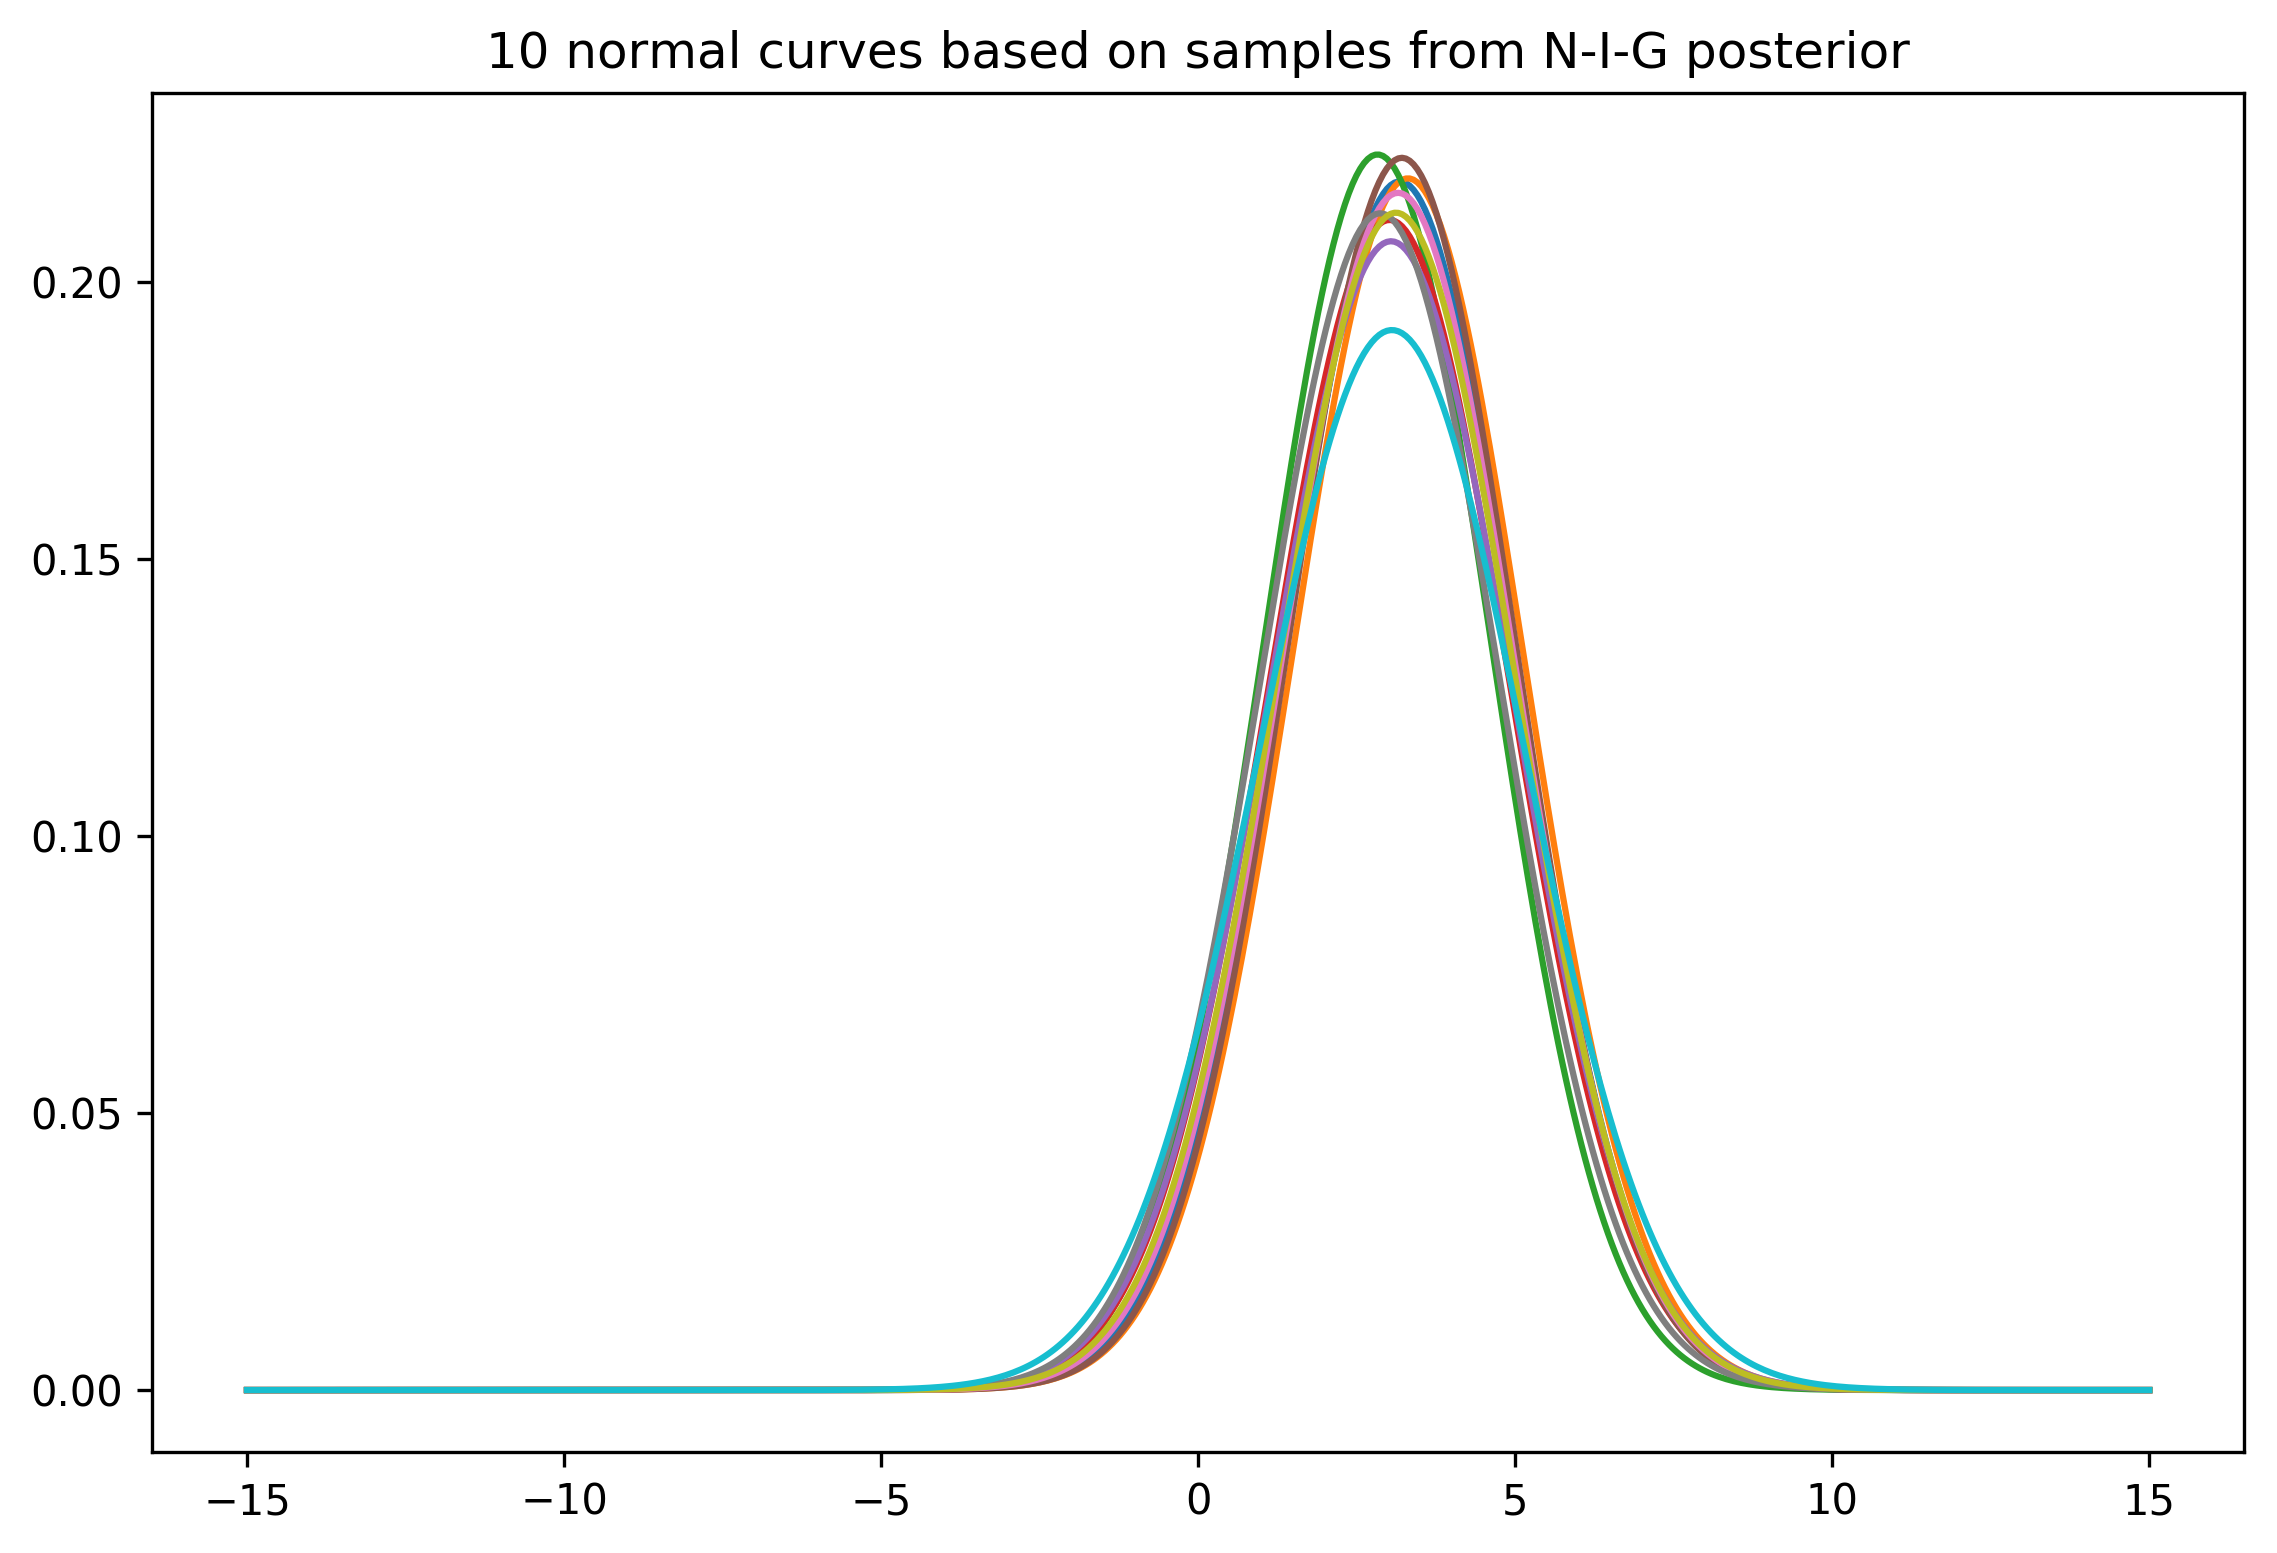

In [15]:
# Extrat samples, pick 10, and plot normal curves
task2_samples = task2_stan_output.extract()
def task2_plot(samples):
    n = 10
    sample_index = np.random.choice(range(len(samples['mu'])), size=n)
    mu_samples = samples['mu'][sample_index]
    sigma2_samples = samples['sigma2'][sample_index]
    x = np.linspace(-15, 15, 500)
    for mu, sigma2 in zip(mu_samples, sigma2_samples):
        y = stats.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2))
        plt.plot(x, y)
task2_plot(task2_samples)
plt.title("10 normal curves based on samples from N-I-G posterior")
plt.show()

# Log-normal HRTEM data.

In [17]:
# Load and transform data
def task3_load_data():
    data = np.loadtxt('hrtem.csv')
    # Log transform
    log_data = np.log(data)
    return data, log_data
task3_data, task3_log_data = task3_load_data()

In [18]:
# We can use the same Stan model compiled in Task 2
task3_stan_model = task2_stan_model

In [19]:
# Gather input data for Stan model
task3_stan_input = {
    'nobs': len(task3_log_data),
    'y': task3_log_data,
    'mu_0': 2.3,
    'lambda': 0.1,
    'alpha': 2,
    'beta': 5
}

In [20]:
# Sample from posterior
task3_stan_output = task3_stan_model.sampling(data=task3_stan_input)

## 95% posterior confidence intervals for the $\mu$ and variance $\sigma^2$ of the log-transformed data.

In [21]:
# Get confidence interval from Stan output and print
task3_mu_summary = task3_stan_output.summary(pars=['mu'], 
                                             probs=[0.025, 0.975])
task3_sigma2_summary = task3_stan_output.summary(pars=['sigma2'], 
                                                 probs=[0.025, 0.975])

print "mu\t\t", "\t\t".join(task3_mu_summary["summary_colnames"][3:5])
print "\t\t","\t".join(task3_mu_summary["summary"][0][3:5].astype(str))
print "\nsigma^2\t\t", "\t\t".join(task3_sigma2_summary["summary_colnames"][3:5])
print "\t\t","\t".join(task3_sigma2_summary["summary"][0][3:5].astype(str))

mu		2.5%		97.5%
		1.83297125246	1.95195683842

sigma^2		2.5%		97.5%
		0.436372332391	0.559671008959


## Take 10 samples from your posterior over $\mu$ and $\sigma^2$ and plot the log-normal distributions corresponding to them. 

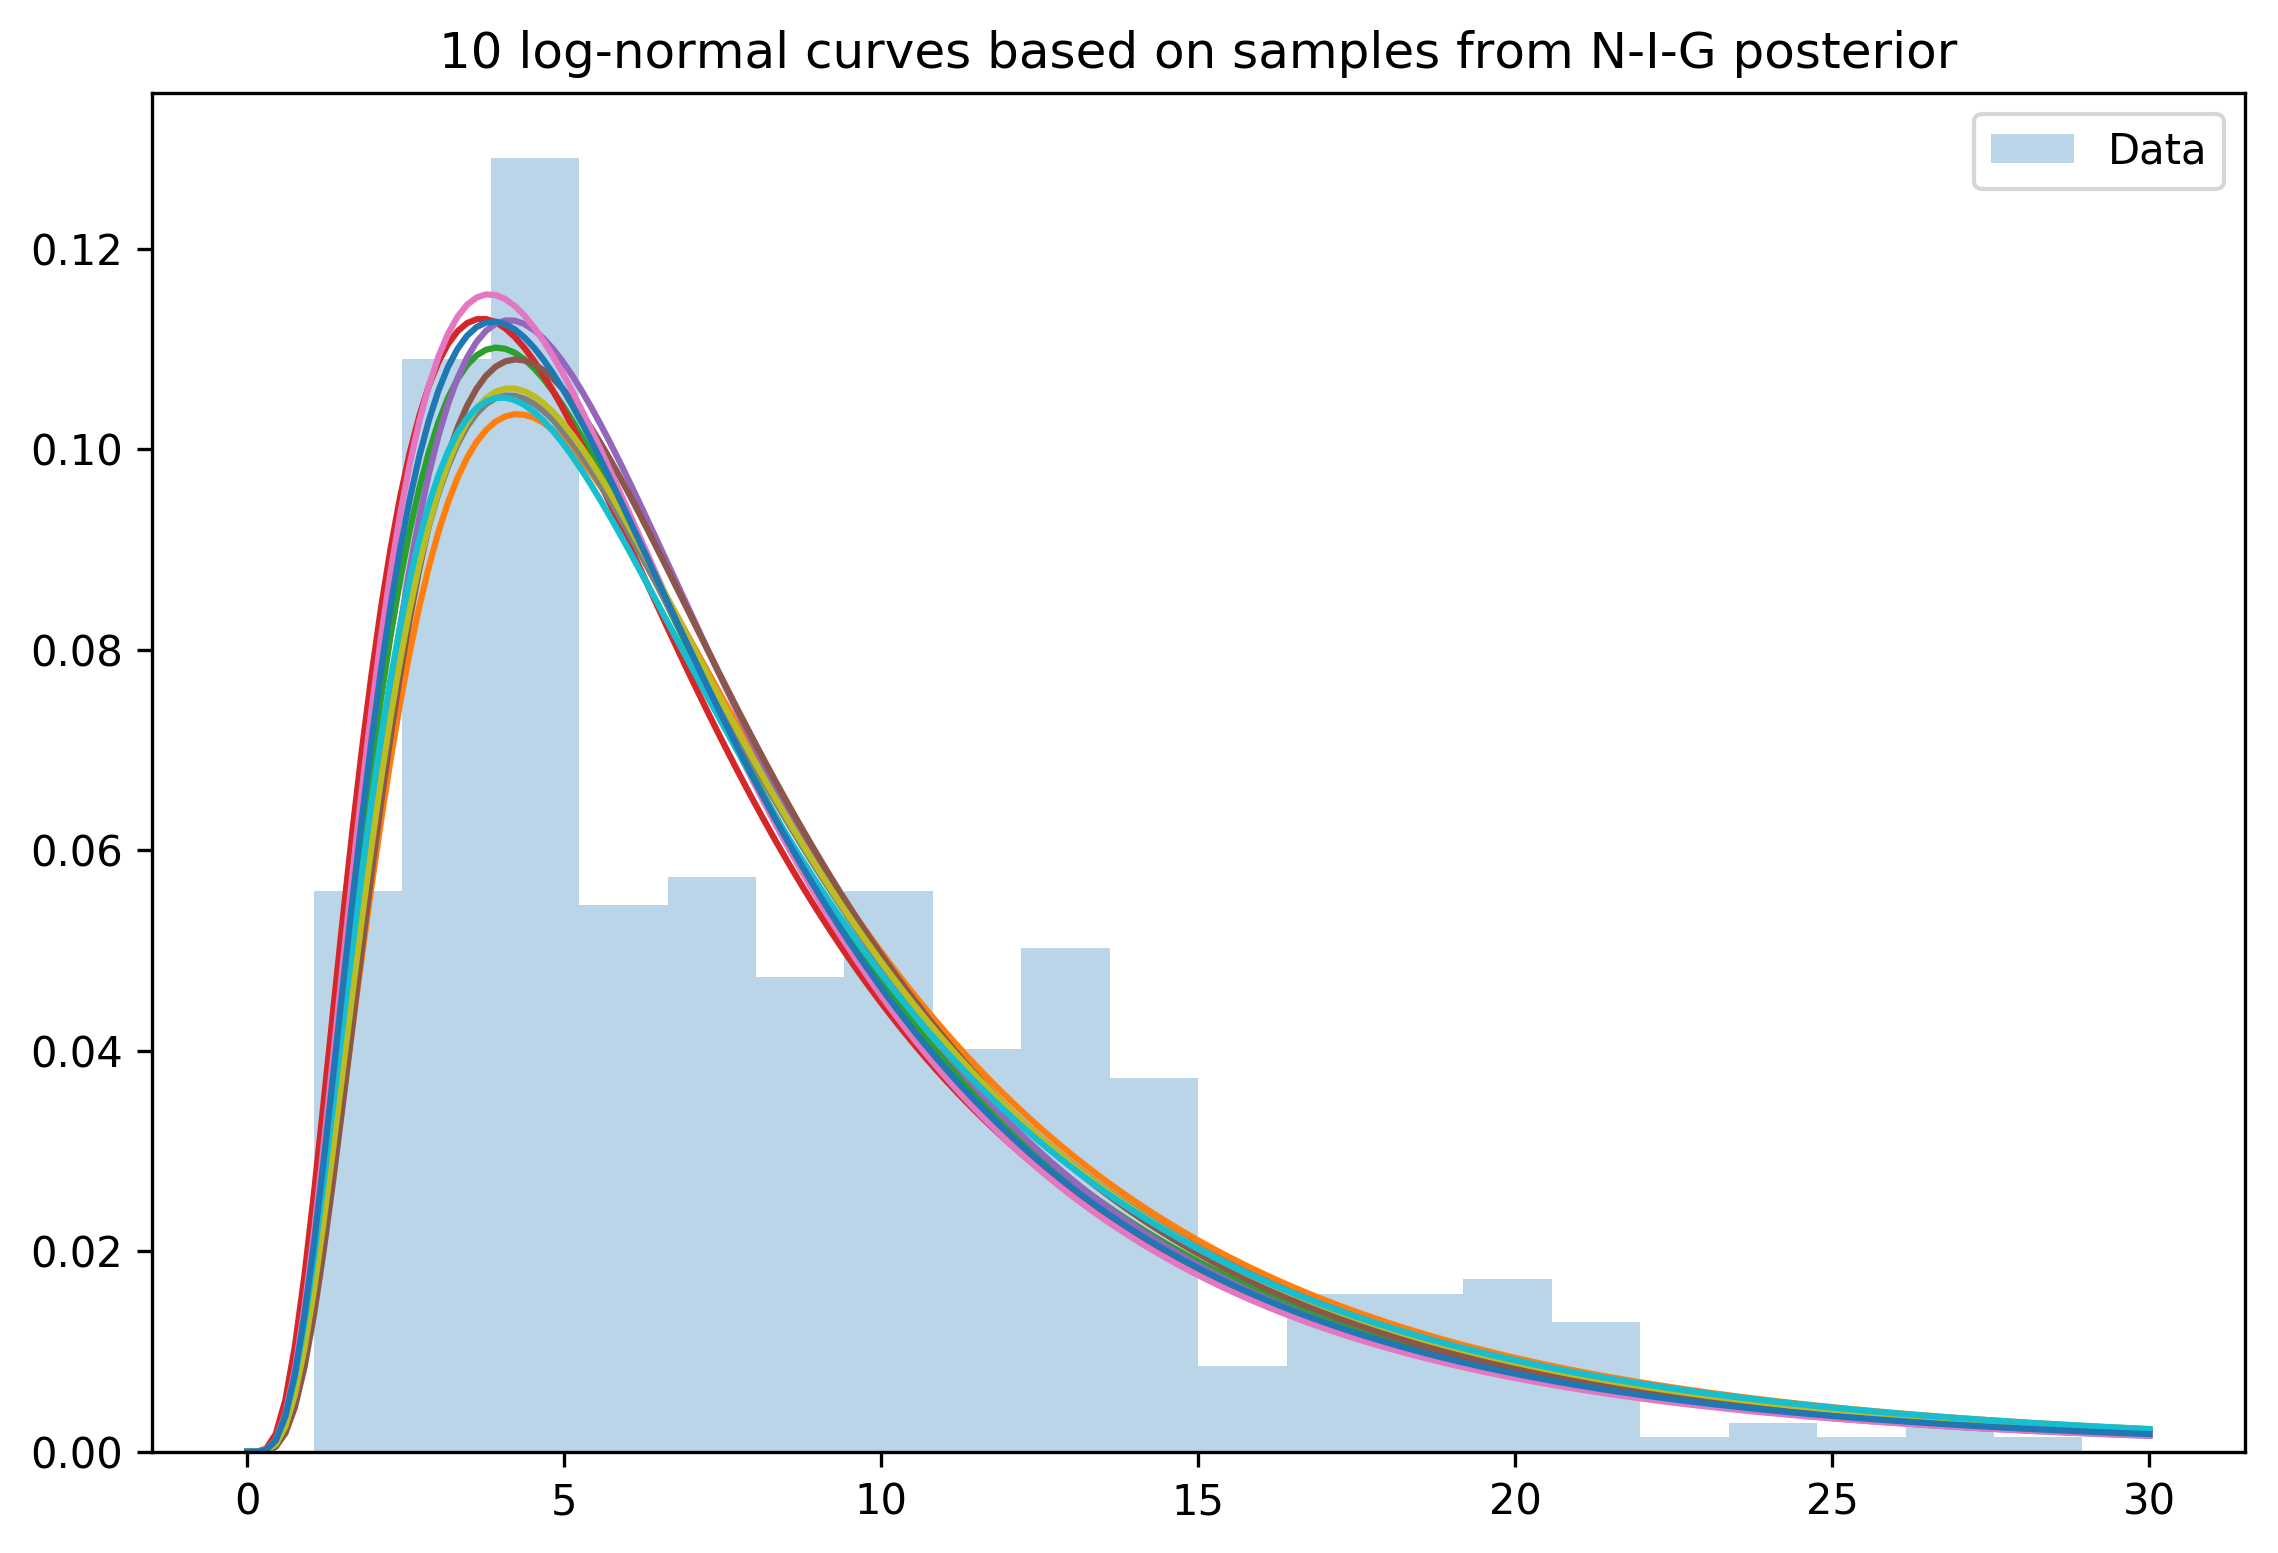

In [22]:
# Extract samples, pick 10, and plot log-normal curves
task3_samples = task3_stan_output.extract()
def task3_curves(samples):
    n = 10
    sample_index = np.random.choice(range(len(samples['mu'])), size=n)
    mu_samples = samples['mu'][sample_index]
    sigma2_samples = samples['sigma2'][sample_index]
    x = np.linspace(0, 30, 200)
    for mu, sigma2 in zip(mu_samples, sigma2_samples):
        y = stats.lognorm.pdf(x, np.sqrt(sigma2), scale=np.exp(mu))
        plt.plot(x, y)

plt.hist(task3_data, bins=20, density=True, alpha=0.3, label="Data")
task3_curves(task3_samples)
plt.legend()
plt.title("10 log-normal curves based on samples from N-I-G posterior")
plt.show()
